In [30]:
import pandas as pd
from collections import defaultdict


In [33]:
df= pd.read_csv("combined_file.csv")
df.columns

Index(['Material ID', 'Space Group', 'Formula', 'Central Atom',
       'Local Magnetization', 'Total Magnetization', '1st Neighbor Distance',
       'Total Atoms in 1st Neighbor', '1st Neighbor Details',
       '2nd Neighbor Distance', 'Total Atoms in 2nd Neighbor',
       '2nd Neighbor Details', '3rd Neighbor Distance',
       'Total Atoms in 3rd Neighbor', '3rd Neighbor Details',
       '4th Neighbor Distance', 'Total Atoms in 4th Neighbor',
       '4th Neighbor Details'],
      dtype='object')

In [34]:
df.head()

,Material ID,Space Group,Formula,Central Atom,Local Magnetization,Total Magnetization,1st Neighbor Distance,Total Atoms in 1st Neighbor,1st Neighbor Details,2nd Neighbor Distance,Total Atoms in 2nd Neighbor,2nd Neighbor Details,3rd Neighbor Distance,Total Atoms in 3rd Neighbor,3rd Neighbor Details,4th Neighbor Distance,Total Atoms in 4th Neighbor,4th Neighbor Details
0,mp-1194100,Pbcm,Mn3O4,Mn,3.833,51.999222,1.884,4,O(4),3.141,6,Mn(6),3.689,6,O(6),3.931,2,Mn(2)
1,mp-1194100,Pbcm,Mn3O4,O,-0.071,51.999222,2.133,4,Mn(4),2.768,2,O(2),3.169,2,O(2),3.520,6,O(6)
2,mp-1246223,P2_1/m,Mn3CoN3,Co,-0.497,11.954403,1.861,3,N(3),2.786,4,Mn(4),2.913,4,Mn(4),3.016,2,Co(2)
3,mp-1246223,P2_1/m,Mn3CoN3,Mn,2.339,11.954403,1.953,4,N(4),2.706,4,Mn(4),2.786,2,Co(2),2.928,1,Co(1)
4,mp-1246223,P2_1/m,Mn3CoN3,N,-0.072,11.954403,1.909,3,"Co(1), Mn(2)",1.965,2,Mn(2),2.748,3,N(3),2.866,2,N(2)


Neighborhood Configurations and Their Magnetization:
                                    Configuration  Total Magnetization  \
35040                         O(3)|O(1)|O(1)|O(1)            26.167926   
29780                         O(2)|O(2)|O(1)|O(1)            28.886851   
26183                         O(1)|O(2)|O(2)|O(1)            18.413630   
26497                         O(1)|O(3)|O(1)|O(1)            22.606054   
28823                         O(2)|O(1)|O(1)|O(1)            29.123240   
...                                           ...                  ...   
23650                 N(2)|I(3)|Ce(1)|Ce(1), I(2)            14.003727   
23651                        N(2)|I(4)|Mg(2)|N(6)            11.993132   
23652  N(2)|Li(2), N(1)|Li(2), Mn(2)|Li(2), Mn(1)            17.112943   
23653                      N(2)|Li(5)|Li(3)|Li(2)            17.112943   
67882                     Zr(6)|S(6)|Zr(6)|Zr(15)            11.795761   

       Frequency  
35040        230  
29780        228  
2

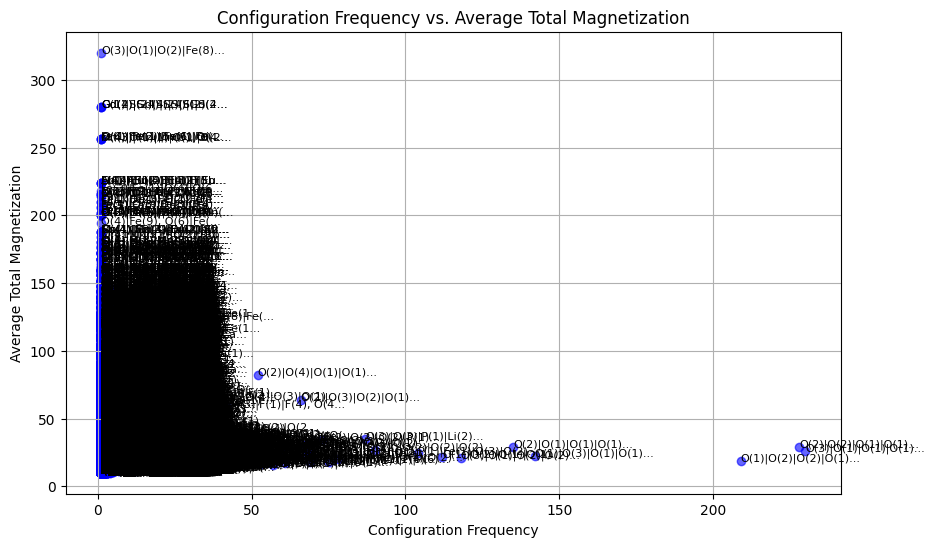

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


df = df

# Create a unique configuration identifier by combining neighbor details
df['Configuration'] = df.apply(
    lambda row: f"{row['1st Neighbor Details']}|{row['2nd Neighbor Details']}|{row['3rd Neighbor Details']}|{row['4th Neighbor Details']}",
    axis=1
)

# Count the frequency of each configuration
config_counts = Counter(df['Configuration'])
config_freq = pd.DataFrame.from_dict(config_counts, orient='index', columns=['Frequency']).reset_index()
config_freq = config_freq.rename(columns={'index': 'Configuration'})

# Merge frequency back to the original dataframe
df = df.merge(config_freq, on='Configuration', how='left')

# Group by configuration to get average total magnetization
config_magnetization = df.groupby('Configuration').agg({
    'Total Magnetization': 'mean',
    'Frequency': 'first'
}).reset_index()

# Sort by frequency to identify the most common configurations
config_magnetization = config_magnetization.sort_values(by='Frequency', ascending=False)

# Print the results
print("Neighborhood Configurations and Their Magnetization:")
print(config_magnetization)

# Plot: Frequency vs Total Magnetization
plt.figure(figsize=(10, 6))
plt.scatter(config_magnetization['Frequency'], config_magnetization['Total Magnetization'], color='b', alpha=0.6)
plt.xlabel('Configuration Frequency')
plt.ylabel('Average Total Magnetization')
plt.title('Configuration Frequency vs. Average Total Magnetization')
plt.grid(True)

# Annotate points with configuration (optional, can be cluttered for large datasets)
for i, row in config_magnetization.iterrows():
    plt.annotate(row['Configuration'][:20] + '...', (row['Frequency'], row['Total Magnetization']), fontsize=8)

plt.savefig('config_magnetization_plot.png')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re

df = df

# Function to count unique elements in neighbor details
def count_unique_elements(neighbor_str):
    # Handle non-string inputs (e.g., NaN, float)
    if not isinstance(neighbor_str, str):
        return 0
    # Extract elements (e.g., 'Co(1), Mn(2)' -> ['Co', 'Mn'])
    elements = [e.split('(')[0] for e in re.split(',\\s*', neighbor_str)]
    return len(set(elements))

# Handle NaN and non-string values in neighbor details
neighbor_cols = ['1st Neighbor Details', '2nd Neighbor Details', '3rd Neighbor Details', '4th Neighbor Details']
for col in neighbor_cols:
    df[col] = df[col].fillna('').astype(str)

# Create configuration
df['Configuration'] = df.apply(
    lambda row: f"{row['1st Neighbor Details']}|{row['2nd Neighbor Details']}|{row['3rd Neighbor Details']}|{row['4th Neighbor Details']}",
    axis=1
)

# Count unique elements per neighbor
df['Unique_1st'] = df['1st Neighbor Details'].apply(count_unique_elements)
df['Unique_2nd'] = df['2nd Neighbor Details'].apply(count_unique_elements)
df['Unique_3rd'] = df['3rd Neighbor Details'].apply(count_unique_elements)
df['Unique_4th'] = df['4th Neighbor Details'].apply(count_unique_elements)
df['Unique_Config'] = df.apply(
    lambda row: (row['Unique_1st'], row['Unique_2nd'], row['Unique_3rd'], row['Unique_4th']),
    axis=1
)

# Count frequency of each configuration
config_counts = Counter(df['Configuration'])
config_freq = pd.DataFrame.from_dict(config_counts, orient='index', columns=['Frequency']).reset_index()
config_freq = config_freq.rename(columns={'index': 'Configuration'})

# Merge frequency with original dataframe
df = df.merge(config_freq, on='Configuration', how='left')
# Fill NaN frequencies with 0
df['Frequency'] = df['Frequency'].fillna(0).astype(int)

# Group by configuration to get average total magnetization and unique config
config_magnetization = df.groupby('Configuration').agg({
    'Total Magnetization': 'mean',
    'Frequency': 'first',
    'Unique_Config': 'first'
}).reset_index()

# Group by unique configuration counts
unique_groups = config_magnetization.groupby('Unique_Config')

# Plotting
plt.figure(figsize=(12, 8))
for unique_config, group in unique_groups:
    plt.scatter(
        group['Frequency'],
        group['Total Magnetization'],
        label=f'Unique Counts: {unique_config}',
        alpha=0.6
    )
plt.xlabel('Configuration Frequency')
plt.ylabel('Average Total Magnetization')
plt.title('Configuration Frequency vs. Average Total Magnetization by Unique Element Counts')
plt.legend()
plt.grid(True)
plt.savefig('config_magnetization_by_unique_counts.png')

In [41]:
import seaborn as sns


In [ ]:
# Function to count unique elements in neighbor details
def count_unique_elements(neighbor_str):
    # Handle non-string inputs (e.g., NaN, float)
    if not isinstance(neighbor_str, str):
        return 0
    # Extract elements (e.g., 'Co(1), Mn(2)' -> ['Co', 'Mn'])
    elements = [e.split('(')[0] for e in re.split(',\\s*', neighbor_str)]
    return len(set(elements))

# Handle NaN and non-string values in neighbor details
neighbor_cols = ['1st Neighbor Details', '2nd Neighbor Details', '3rd Neighbor Details', '4th Neighbor Details']
for col in neighbor_cols:
    df[col] = df[col].fillna('').astype(str)

# Create configuration
df['Configuration'] = df.apply(
    lambda row: f"{row['1st Neighbor Details']}|{row['2nd Neighbor Details']}|{row['3rd Neighbor Details']}|{row['4th Neighbor Details']}",
    axis=1
)

# Count unique elements per neighbor
df['Unique_1st'] = df['1st Neighbor Details'].apply(count_unique_elements)
df['Unique_2nd'] = df['2nd Neighbor Details'].apply(count_unique_elements)
df['Unique_3rd'] = df['3rd Neighbor Details'].apply(count_unique_elements)
df['Unique_4th'] = df['4th Neighbor Details'].apply(count_unique_elements)
df['Unique_Config'] = df.apply(
    lambda row: (row['Unique_1st'], row['Unique_2nd'], row['Unique_3rd'], row['Unique_4th']),
    axis=1
)

# Count frequency of each configuration
config_counts = Counter(df['Configuration'])
config_freq = pd.DataFrame.from_dict(config_counts, orient='index', columns=['Frequency']).reset_index()
config_freq = config_freq.rename(columns={'index': 'Configuration'})

# Drop existing 'Frequency' column to avoid merge conflicts
if 'Frequency' in df.columns:
    df = df.drop(columns=['Frequency'])

# Merge frequency with original dataframe
df = df.merge(config_freq, on='Configuration', how='left')
df['Frequency'] = df['Frequency'].fillna(0).astype(int)

# Group by configuration to get average total magnetization and unique config
config_magnetization = df.groupby('Configuration').agg({
    'Total Magnetization': 'mean',
    'Frequency': 'first',
    'Unique_Config': 'first'
}).reset_index()



# Plot 1: Individual Scatter Plots per Unique Configuration
unique_groups = config_magnetization.groupby('Unique_Config')
n_groups = len(unique_groups)
fig, axes = plt.subplots(nrows=(n_groups + 1) // 2, ncols=2, figsize=(15, 5 * ((n_groups + 1) // 2)), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (unique_config, group) in enumerate(unique_groups):
    axes[idx].scatter(group['Frequency'], group['Total Magnetization'], alpha=0.6)
    axes[idx].set_title(f'Unique Counts: {unique_config}')
    axes[idx].set_xlabel('Configuration Frequency')
    axes[idx].set_ylabel('Average Total Magnetization')
    axes[idx].grid(True)

# Remove empty subplots
for idx in range(len(unique_groups), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('individual_config_scatter.png')

# Plot 2: Box Plot of Magnetization by Frequency
plt.figure(figsize=(10, 6))
sns.boxplot(x='Frequency', y='Total Magnetization', data=df)
plt.title('Total Magnetization Distribution by Configuration Frequency')
plt.xlabel('Configuration Frequency')
plt.ylabel('Total Magnetization')
plt.grid(True)
plt.savefig('magnetization_by_frequency_boxplot.png')

# Plot 3: Bar Plot of Average Magnetization by Unique Configuration
unique_config_magnetization = config_magnetization.groupby('Unique_Config')['Total Magnetization'].mean().reset_index()
unique_config_magnetization['Unique_Config_Str'] = unique_config_magnetization['Unique_Config'].apply(str)

plt.figure(figsize=(12, 6))
sns.barplot(x='Unique_Config_Str', y='Total Magnetization', data=unique_config_magnetization)
plt.title('Average Total Magnetization by Unique Configuration')
plt.xlabel('Unique Configuration (1st, 2nd, 3rd, 4th Neighbor Unique Counts)')
plt.ylabel('Average Total Magnetization')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig('average_magnetization_by_unique_config.png')

In [50]:
print(config_magnetization)

config_magnetization.to_csv("config_magnetization.csv", index=False)


                                Configuration  Total Magnetization  Frequency  \
0                   Ac(12)|Eu(6)|Eu(2)|Ac(18)            18.728216          1   
1      Ac(4), Eu(8)|Eu(6)|Eu(2)|Ac(6), Eu(12)            45.393970          1   
2       Ac(6), Np(2)|Ac(2), Np(2)|Ac(4)|Ac(2)            11.062529          1   
3                     Ac(6)|Ac(6)|Np(6)|Np(2)            11.062529          1   
4      Ac(8), Eu(4)|Ac(6)|Ac(2)|Ac(12), Eu(6)            18.728216          1   
...                                       ...                  ...        ...   
67878                   Zr(3)|Gd(1)|O(2)|O(2)            55.998213          1   
67879                Zr(6)|Cl(12)|Cl(6)|O(24)            24.982047          1   
67880           Zr(6)|Fe(6)|C(6), Fe(6)|Zr(6)            10.567329          1   
67881     Zr(6)|H(6)|Fe(6)|H(2), O(6), Zr(12)            22.606355          1   
67882                 Zr(6)|S(6)|Zr(6)|Zr(15)            11.795761          1   

      Unique_Config  
0    

In [ ]:
df2 = pd.read_csv("config_magnetization.csv")
df2.columns


Index(['Configuration', 'Total Magnetization', 'Frequency', 'Unique_Config'], dtype='object')

In [49]:
lst1 = df2['Frequency'].to_list()
cnt=0
max=0
for i in lst1:
    if lst1[i]>1:
        cnt = cnt+1
    
    if max<lst1[i]:
        max=lst1[i]
        
print(cnt, max)

117 2


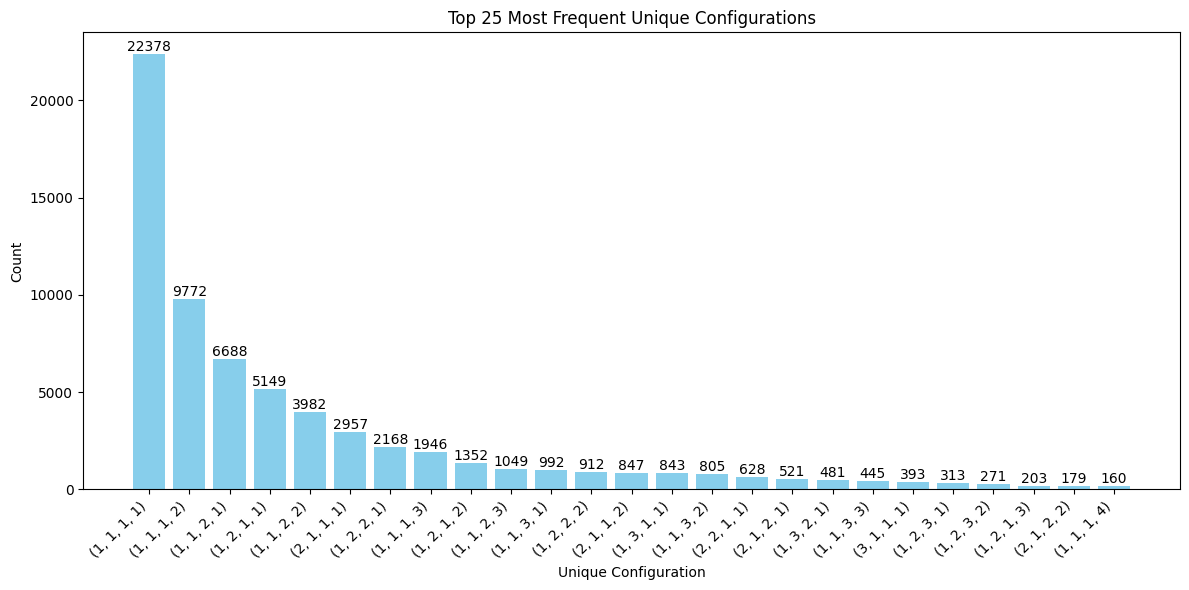

In [76]:
config_magnetization = df2

# Count how often each Unique_Config appears
config_counts = config_magnetization['Unique_Config'].value_counts().reset_index()
config_counts.columns = ['Unique_Config', 'Count']

# Save the counts to a new CSV
config_counts.to_csv("unique_config_counts.csv", index=False)

# Plot the top 10 most frequent Unique_Config values
top_n = 25
top_configs = config_counts.head(top_n)

plt.figure(figsize=(12, 6))
bars = plt.bar(
    x=[str(cfg) for cfg in top_configs['Unique_Config']],
    height=top_configs['Count'],
    color='skyblue'
)

# Add count labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, int(yval), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.title(f"Top {top_n} Most Frequent Unique Configurations")
plt.xlabel("Unique Configuration")
plt.ylabel("Count")
plt.tight_layout()

# Save the plot as an image or display it
plt.savefig("top_unique_configs.png")
plt.show()

In [69]:
df = config_magnetization

# Step 1: Get top 10 most frequent Unique_Config values
top_configs = df['Unique_Config'].value_counts().index

# Step 2: Create a dictionary to hold each subset
separated_datasets = {config: df[df['Unique_Config'] == config] for config in top_configs}

dict = {}
# Step 3: Display the data for each top config
for config in top_configs:
    separated_datasets[config].head() # Display the first few rows of each subset
    mean = separated_datasets[config].head()['Total Magnetization'].mean()
    dict[config]=mean



In [67]:
dict

{'(1, 1, 1, 1)': 18.12382236,
 '(1, 1, 1, 2)': 17.784016080000004,
 '(1, 1, 2, 1)': 38.6300758,
 '(1, 2, 1, 1)': 20.43940178,
 '(1, 1, 2, 2)': 24.30062554,
 '(2, 1, 1, 1)': 17.17274969,
 '(1, 2, 2, 1)': 22.402042619999996,
 '(1, 1, 1, 3)': 18.39501351,
 '(1, 2, 1, 2)': 14.74357642,
 '(1, 1, 2, 3)': 19.301850179999995,
 '(1, 1, 3, 1)': 33.65323062,
 '(1, 2, 2, 2)': 33.35547418,
 '(2, 1, 1, 2)': 22.680567740000004,
 '(1, 3, 1, 1)': 19.5930399,
 '(1, 1, 3, 2)': 25.689440639999997,
 '(2, 2, 1, 1)': 20.09524484,
 '(2, 1, 2, 1)': 21.898022880000003,
 '(1, 3, 2, 1)': 71.99236336,
 '(1, 1, 3, 3)': 17.05983678,
 '(3, 1, 1, 1)': 20.882187140000003,
 '(1, 2, 3, 1)': 37.936559040000006,
 '(1, 2, 3, 2)': 20.799556919999997,
 '(1, 2, 1, 3)': 22.06779064,
 '(2, 1, 2, 2)': 17.20538168,
 '(1, 1, 1, 4)': 15.800572840000001,
 '(1, 2, 2, 3)': 16.1998575,
 '(1, 3, 3, 1)': 38.99990604,
 '(1, 3, 2, 2)': 34.3854903,
 '(2, 2, 2, 1)': 20.03490362,
 '(2, 2, 1, 2)': 24.157397160000002,
 '(1, 2, 3, 3)': 19.2004972

In [72]:
dataset_1_1_1_1 = separated_datasets['(1, 1, 1, 1)'] 
dataset_1_1_1_1

,Configuration,Total Magnetization,Frequency,Unique_Config
0,Ac(12)|Eu(6)|Eu(2)|Ac(18),18.728216,1,"(1, 1, 1, 1)"
3,Ac(6)|Ac(6)|Np(6)|Np(2),11.062529,1,"(1, 1, 1, 1)"
26,Ag(1)|Ag(1)|Ag(1)|Ag(1),16.822431,1,"(1, 1, 1, 1)"
27,Ag(1)|Ag(1)|Ag(2)|Ag(2),32.005936,1,"(1, 1, 1, 1)"
28,Ag(1)|Ag(3)|O(3)|O(3),12.000000,1,"(1, 1, 1, 1)"
...,...,...,...,...
67875,Zr(3)|Eu(1)|Se(2)|Se(7),27.878440,1,"(1, 1, 1, 1)"
67876,Zr(3)|Eu(1)|Se(5)|Se(1),14.037958,1,"(1, 1, 1, 1)"
67878,Zr(3)|Gd(1)|O(2)|O(2),55.998213,1,"(1, 1, 1, 1)"
67879,Zr(6)|Cl(12)|Cl(6)|O(24),24.982047,1,"(1, 1, 1, 1)"


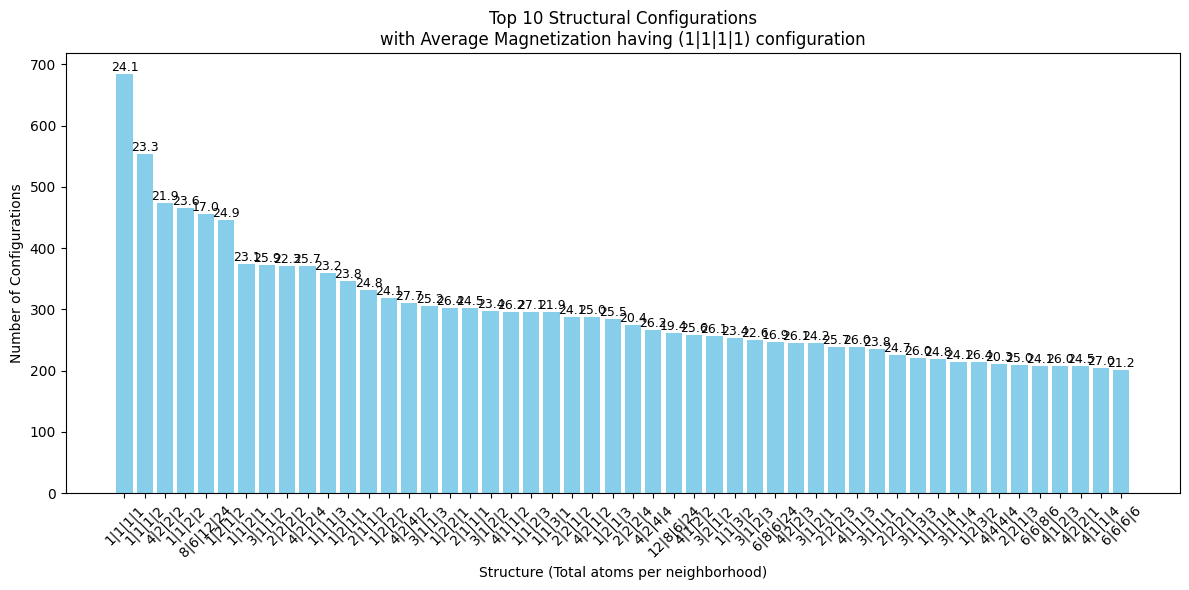

                     Num_Configurations  Avg_Magnetization
Structure_Signature                                       
1|1|1|1                             684          24.124520
1|1|1|2                             553          23.270218
4|2|2|2                             473          21.945568
1|1|2|2                             466          23.587691
8|6|12|24                           456          17.031139
1|2|1|2                             446          24.858947
1|1|2|1                             374          23.064086
3|1|1|2                             373          25.917752
2|2|2|2                             371          22.257213
4|2|2|4                             371          25.666966
1|1|1|3                             360          23.186659
1|2|1|1                             346          23.776205
2|1|1|2                             331          24.816397
1|2|2|2                             318          24.099432
4|2|4|2                             310          27.7015

In [83]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import re

# # Step 1: Use the full dataset
# df = config_magnetization.copy()

# # Step 2: Helper function to count atoms in one neighborhood
# def count_atoms(neighborhood):
#     # Matches all counts inside parentheses, e.g., "O(2), Fe(6)" → [2, 6]
#     counts = map(int, re.findall(r'\((\d+)\)', neighborhood))
#     return sum(counts)

# # Step 3: Split Configuration into 4 neighborhoods
# df[['N1', 'N2', 'N3', 'N4']] = df['Configuration'].str.split('|', expand=True)

# # Step 4: Count atoms in each neighborhood
# df['C1'] = df['N1'].apply(count_atoms)
# df['C2'] = df['N2'].apply(count_atoms)
# df['C3'] = df['N3'].apply(count_atoms)
# df['C4'] = df['N4'].apply(count_atoms)

# # Step 5: Create configuration structure signature (e.g., "3|4|4|2")
# df['Structure_Signature'] = df[['C1', 'C2', 'C3', 'C4']].astype(str).agg('|'.join, axis=1)

# # Step 6: Count top 10 structure signatures
# structure_counts = df['Structure_Signature'].value_counts().head(10)

# # Step 7: Plot
# plt.figure(figsize=(10, 5))
# structure_counts.plot(kind='bar')
# plt.title('Top 10 Structural Configuration Signatures')
# plt.xlabel('Structure (Total atoms per neighborhood)')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import re

# Step 1: Start with the full dataset
df = config_magnetization.copy()

# Step 2: Helper function to count atoms in one neighborhood
def count_atoms(neighborhood):
    counts = map(int, re.findall(r'\((\d+)\)', str(neighborhood)))
    return sum(counts)

# Step 3: Split Configuration into 4 neighborhoods
df[['N1', 'N2', 'N3', 'N4']] = df['Configuration'].str.split('|', expand=True)

# Step 4: Count atoms in each neighborhood
df['C1'] = df['N1'].apply(count_atoms)
df['C2'] = df['N2'].apply(count_atoms)
df['C3'] = df['N3'].apply(count_atoms)
df['C4'] = df['N4'].apply(count_atoms)

# Step 5: Create structure signature like "3|4|4|2"
df['Structure_Signature'] = df[['C1', 'C2', 'C3', 'C4']].astype(str).agg('|'.join, axis=1)

# Step 6: Group by structure signature to get count and mean
summary = df.groupby('Structure_Signature').agg(
    Num_Configurations=('Configuration', 'count'),
    Avg_Magnetization=('Total Magnetization', 'mean')
).sort_values('Num_Configurations', ascending=False).head(50)

# Step 7: Plot frequency with average magnetization as labels
plt.figure(figsize=(12, 6))
bars = plt.bar(summary.index, summary['Num_Configurations'], color='skyblue')
plt.title('Top 10 Structural Configurations\nwith Average Magnetization having (1|1|1|1) configuration')
plt.xlabel('Structure (Total atoms per neighborhood)')
plt.ylabel('Number of Configurations')
plt.xticks(rotation=45)

# Annotate bars with average magnetization
for bar, avg in zip(bars, summary['Avg_Magnetization']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{avg:.1f}", ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# Optional: print the summary DataFrame
print(summary)
